**Problem Statement:** Prediction task is to determine whether a person's income is over $50,000 a year. We will use explainable models to see what features lead to higher incomes.

# Libraries

In [ ]:
# Data manipulation
import pandas as pd
import numpy as np

# Data source
from ucimlrepo import fetch_ucirepo

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import plot_importance
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

# Core
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

# Preprocessing
from sklearn.preprocessing import StandardScaler
from category_encoders import CatBoostEncoder

# Models
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, classification_report)

# Read in Data

In [ ]:
# fetch dataset 
adult = fetch_ucirepo(id=2) # this dataset is sourced from the UCI machine learning repository
  
# data (as pandas dataframes) 
X = adult.data.features # features
y = adult.data.targets  # response (income)
  
# metadata 
print(adult.metadata) 
  
# variable information 
print(adult.variables) 


{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the fol

In [ ]:
# drop redundant features
X = X.drop(columns=['fnlwgt', 'education-num'])

# EDA and Data Prep

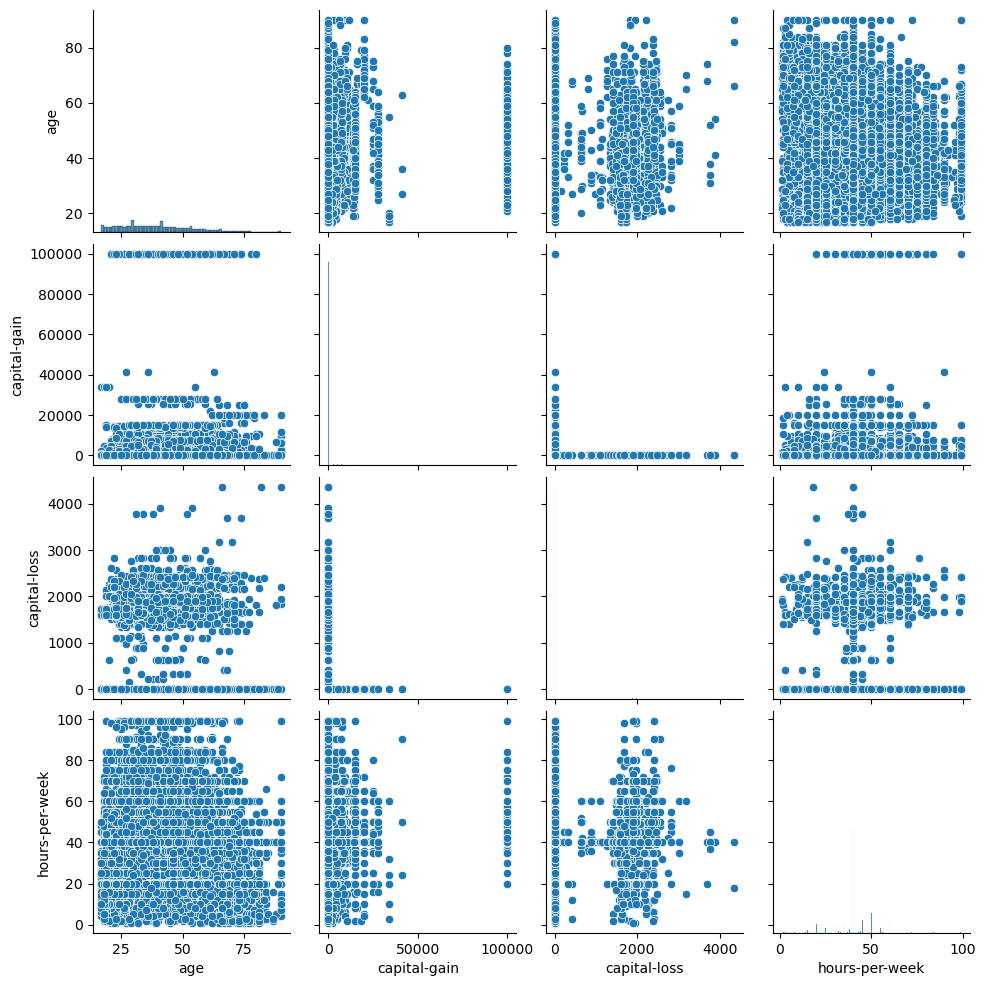

In [ ]:
sns.pairplot(data=X) # check for multicollinearity

In [ ]:
y['income'].unique() # we can see that there are some data entry errors in the response variable

array(['<=50K', '>50K', '<=50K.', '>50K.'], dtype=object)

In [ ]:
y.loc[:, 'income'] = y['income'].replace({
    '<=50K.' : '<=50K',
    '>50K.' : '>50K'
}) # Remove "." from response

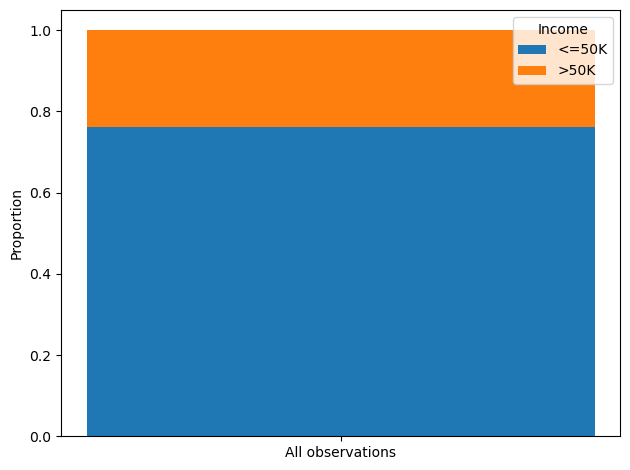

In [23]:
# count income categories
counts = y['income'].value_counts()

counts_pct = counts / counts.sum()

plt.bar(
    ['All observations'],
    [counts_pct.get('<=50K', 0)],
    label='<=50K'
)

plt.bar(
    ['All observations'],
    [counts_pct.get('>50K', 0)],
    bottom=[counts_pct.get('<=50K', 0)],
    label='>50K'
)

plt.ylabel('Proportion')
plt.legend(title='Income')
plt.tight_layout()
plt.show()

We can see that ~22% of observations have an income greater than $50,000, there is no need to do under or oversampling for rare event modeling.

In [ ]:
X = X.fillna('missing') # Missing values are only in categorical features, so we just add another level for missing in those columns

In [ ]:
y = y['income'].map({'>50K': 1, '<=50K': 0}) # convert response to binary

# split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=67,
    stratify=y
)

# Modeling

In [ ]:
# test with multiple models
models = {
    'LogisticRegression': LogisticRegression(max_iter=10000),
    'RandomForest': RandomForestClassifier(random_state=67),
    'Ridge': RidgeClassifier(),
    'Lasso': LogisticRegression(penalty='l1', solver='liblinear', max_iter=10000),    
    'DecisionTree': DecisionTreeClassifier(random_state=67),
    'GaussianNB': GaussianNB(),
    'XGBoost': XGBClassifier(random_state=67)
    }

# cross validation scoring metrics
scoring = {
    'roc_auc': 'roc_auc',
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

print(f'{"Model":<20} {"ROC_AUC":<10} {"ACC":<8} {"PREC":<8} {"REC":<8} {"F1":<8}')
print('=' * 70)

for name, model in models.items():
    pipe = make_pipeline(CatBoostEncoder(), StandardScaler(), model)
    
    scores = cross_validate(
        pipe,
        X_train,
        y_train,
        cv=5,
        scoring=scoring
    )
    
    # create a table of cross validation metrics
    print(
        f'{name:<20} '
        f'{scores["test_roc_auc"].mean():<10.4f} '
        f'{scores["test_accuracy"].mean():<8.4f} '
        f'{scores["test_precision"].mean():<8.4f} '
        f'{scores["test_recall"].mean():<8.4f} '
        f'{scores["test_f1"].mean():<8.4f}'
    )

Model                ROC_AUC    ACC      PREC     REC      F1      
LogisticRegression   0.9003     0.8471   0.7353   0.5638   0.6382  
RandomForest         0.9113     0.8596   0.7610   0.6026   0.6724  
Ridge                0.8907     0.8347   0.7512   0.4623   0.5723  
Lasso                0.9003     0.8471   0.7354   0.5639   0.6383  
DecisionTree         0.7444     0.8086   0.5966   0.6212   0.6084  
GaussianNB           0.8826     0.8324   0.6842   0.5567   0.6139  
XGBoost              0.9246     0.8686   0.7656   0.6530   0.7031  


After training seven models, XGBoost demonstrated the strongest overall performance under five-fold cross-validation. We therefore select XGBoost as the final model to examine how different features contribute to an individual’s likelihood of earning more than $50,000.

# Evaluate XGBoost on Test Data

In [ ]:
# fit
xgb = XGBClassifier(random_state=67)
pipe = make_pipeline(CatBoostEncoder(), StandardScaler(), xgb)
pipe.fit(X_train, y_train)

# predict
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

# metrics
print("\nClassification report:\n", classification_report(y_test, y_pred))


Classification report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.92      7431
           1       0.76      0.68      0.72      2338

    accuracy                           0.87      9769
   macro avg       0.83      0.81      0.82      9769
weighted avg       0.87      0.87      0.87      9769



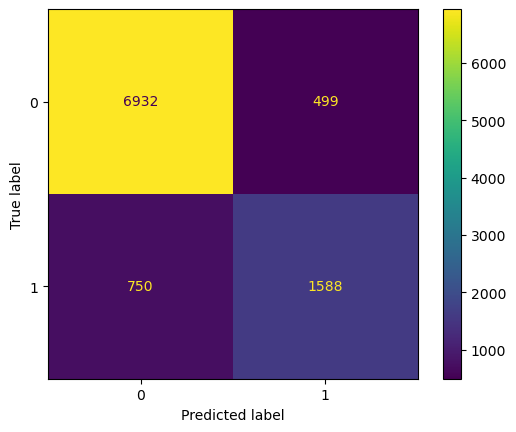

In [30]:
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(cm).plot()
plt.show()

On the held-out test set, the final model achieved an accuracy of 87%. For the positive class (income over $50,000), it attains a precision of 0.76 and a recall of 0.68, indicating a solid ability to identify higher-income individuals while balancing false positives and false negatives.

# Feature Importance

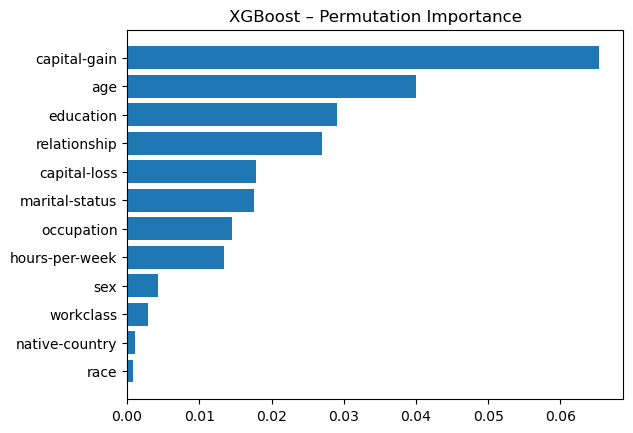

In [ ]:
r = permutation_importance(
    pipe, 
    X_test, 
    y_test, 
    n_repeats=10, 
    random_state=67, 
    scoring='roc_auc')

sorted_idx = r.importances_mean.argsort()
plt.barh(np.array(X.columns)[sorted_idx], r.importances_mean[sorted_idx])
plt.title("XGBoost - Permutation Importance")
plt.show()

The permutation importance plot displays which inputs matter most to the model's predictions. Specifically, it measures how much the model’s ROC AUC—its overall ability to discriminate between positive and negative cases—decreases when each variable is randomly shuffled.

/opt/anaconda3/envs/env1/lib/python3.12/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 8 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


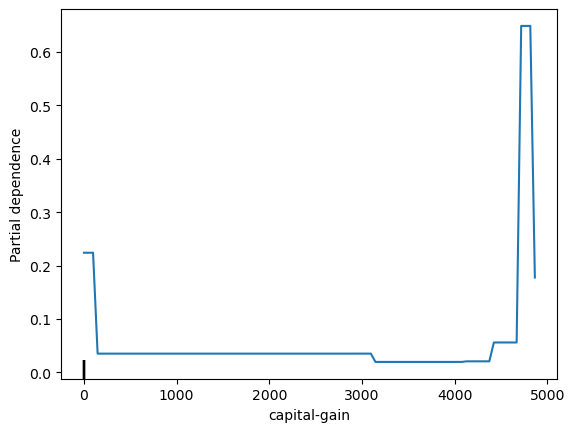

In [50]:
fig = PartialDependenceDisplay.from_estimator(
    pipe, 
    X_train, 
    features=['capital-gain']
)
plt.show()

This partial dependence plot shows that a person's income is more likely to be greater than $50,000 if their reported capital-gains are over $5,000 (obviously).

/opt/anaconda3/envs/env1/lib/python3.12/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


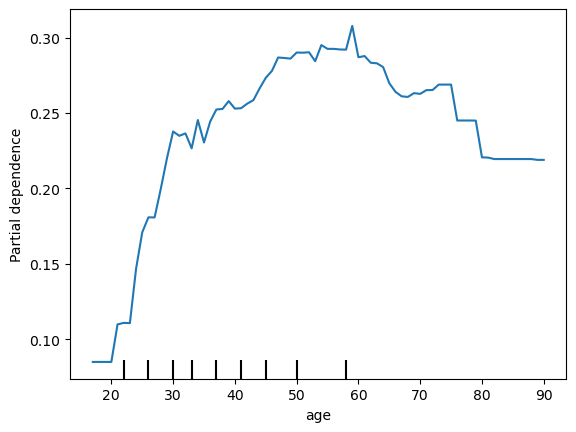

In [51]:
fig = PartialDependenceDisplay.from_estimator(
    pipe, 
    X_train, 
    features=['age']
)
plt.show()

From this partial dependence plot, we see that the likelihood of the event increases with age initially, but then begins to decline around retirement age. This is consistent with our intuition because you should make more money as you gain experience and you will make less money when you retire because you aren't working anymore.

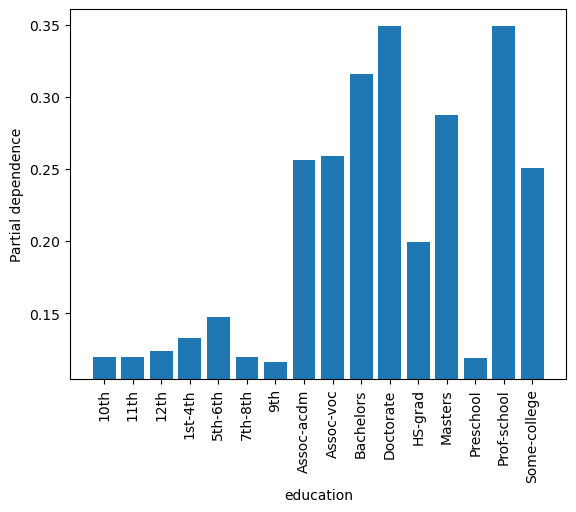

In [52]:
fig = PartialDependenceDisplay.from_estimator(
    pipe, 
    X_train, 
    features=['education'],
    categorical_features=['education']
)
plt.show()

This partial dependence plot indicates that higher levels of educational attainment are generally associated with a higher likelihood of earning more than $50,000. (Before presenting this plot to stakeholders, the education categories would be reordered to reflect a more intuitive, sequential progression.)

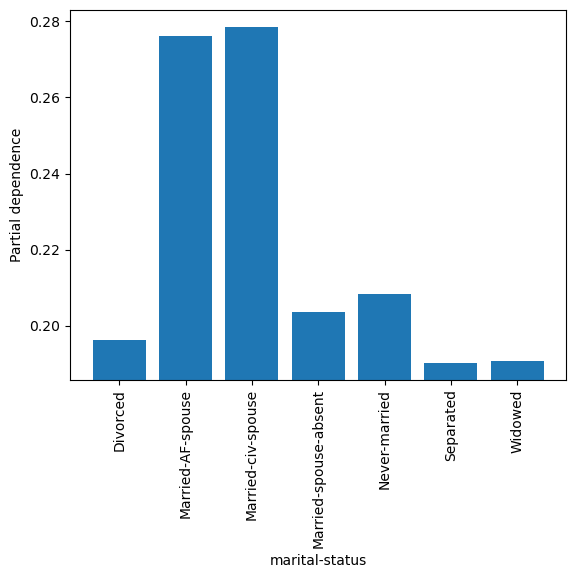

In [54]:
fig = PartialDependenceDisplay.from_estimator(
    pipe, 
    X_train, 
    features=['marital-status'],
    categorical_features=['marital-status']
)
plt.show()

From this partial dependence plot we can see that people who are married have a higher likelihood of having an income greater than $50,000.

# Conclusion

In this project, we developed and evaluated multiple classification models to predict whether an individual earns more than $50,000 per year using demographic and employment-related features. After comparing seven models via five-fold cross-validation, XGBoost consistently demonstrated the strongest overall performance and was selected as the final model.

On the held-out test set, the model achieved an accuracy of 87% and showed strong performance on the positive class (income over $50,000), balancing precision and recall despite class imbalance. Feature-based analysis provided insight into how variables such as education, age, and capital gains contribute to higher income levels. Overall, this project highlights the value of combining robust model selection with interpretability to produce reliable and actionable insights from structured socioeconomic data.